<a href="https://colab.research.google.com/github/rohaan-ahmed/Master-Repository/blob/master/Anomaly%20Detection/U_Net_and_Small_Autoencoder_for_Image_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loading libraries, frameworks, and magic
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image as PIL_Image
import numpy as np
import matplotlib.image as mpimg
import random
import pickle as pkl

# Importing Keras and TensorFlow libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout
from keras.models import Model, load_model
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

In [ ]:
data_path = '/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1/'
train_path = os.listdir(data_path + "Train_all_imgs")

**U-Net Autoencoder**

In [ ]:
IMG_ORG_HEIGHT = 158
IMG_ORG_WIDTH = 238

IMG_RESIZE_HEIGHT = 256
IMG_RESIZE_WIDTH = 512
IMG_CHANNELS = 1

In [ ]:

inputs = tf.keras.layers.Input((IMG_RESIZE_HEIGHT, IMG_RESIZE_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(IMG_CHANNELS, (1, 1), activation='sigmoid')(c9)
 
ISUnet_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
ISUnet_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
ISUnet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 512, 16) 2320        dropout[0][0]                    
_______________________________________________________________________________________

In [ ]:
batch_size = 25
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', validation_split=0.2)

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 
model_filepath = data_path + '../saved_models/unet_model1.keras'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min')

train_generator = train_datagen.flow_from_directory(
    directory = data_path,
    target_size=(IMG_RESIZE_HEIGHT, IMG_RESIZE_WIDTH),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False,
    class_mode='input',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    directory = data_path,
    target_size=(IMG_RESIZE_HEIGHT, IMG_RESIZE_WIDTH),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False,
    class_mode='input',
    subset='validation')

Found 5440 images belonging to 1 classes.
Found 1360 images belonging to 1 classes.


In [ ]:
# Training the Model

results_Unet = ISUnet_model.fit(train_generator,
    epochs=100,
    shuffle = False,
    validation_data = val_generator, 
    callbacks=[es, save_best])

Epoch 1/100
218/218 [==============================] - 2116s 10s/step - loss: 0.0082 - accuracy: 3.8641e-05 - val_loss: 0.0014 - val_accuracy: 3.8882e-05
Epoch 2/100
218/218 [==============================] - 104s 479ms/step - loss: 6.1593e-04 - accuracy: 4.0192e-05 - val_loss: 0.0019 - val_accuracy: 3.8882e-05
Epoch 3/100
218/218 [==============================] - 108s 494ms/step - loss: 4.1811e-04 - accuracy: 4.0192e-05 - val_loss: 0.0015 - val_accuracy: 3.8882e-05
Epoch 4/100
218/218 [==============================] - 109s 502ms/step - loss: 3.3358e-04 - accuracy: 4.0192e-05 - val_loss: 0.0013 - val_accuracy: 3.8882e-05
Epoch 5/100
218/218 [==============================] - 109s 501ms/step - loss: 2.8110e-04 - accuracy: 4.0192e-05 - val_loss: 0.0013 - val_accuracy: 3.8882e-05
Epoch 6/100
218/218 [==============================] - 109s 501ms/step - loss: 2.4492e-04 - accuracy: 4.0192e-05 - val_loss: 0.0011 - val_accuracy: 3.8882e-05
Epoch 7/100
218/218 [==============================

In [ ]:
model = keras.models.load_model(model_filepath)

In [ ]:
data_list = []
batch_index = 0
while batch_index <= val_generator.batch_index:
    data = val_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

6


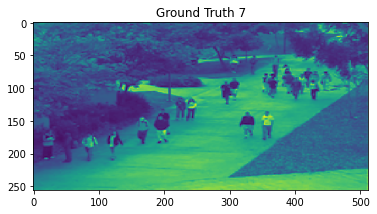

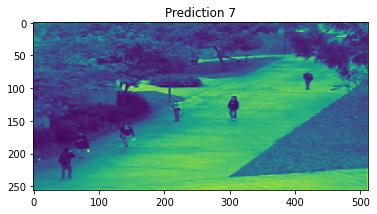

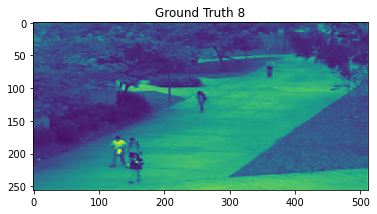

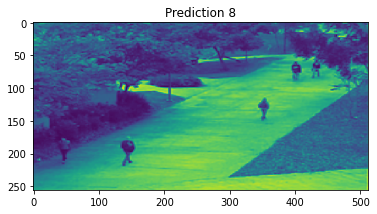

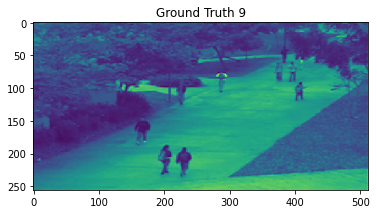

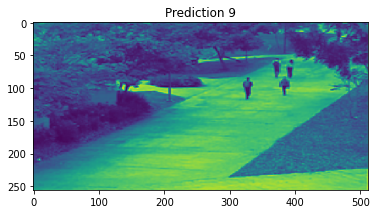

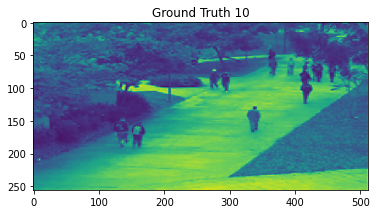

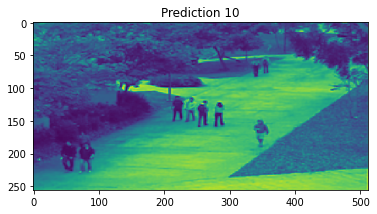

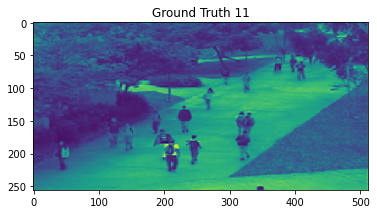

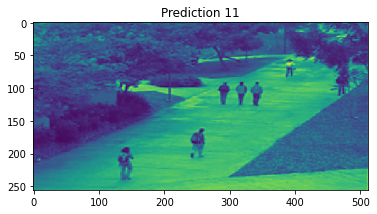

In [ ]:
predicted = model.predict(data_list[0])
no_of_samples = 5
idx = random.randint(0, len(predicted)-no_of_samples-1)
print(idx)
for i in range(idx, idx + no_of_samples):
    img = data_list[i][i][:][:]
    plt.imshow(img[:,:,0])
    plt.title('Ground Truth ' + str(i+1))
    plt.show()

    img = predicted[i][:][:]
    plt.imshow(img[:,:,0])
    plt.title('Prediction ' + str(i+1))
    plt.show()

**Small Autoencoder**

In [ ]:

input_img = keras.Input(shape=(IMG_RESIZE_HEIGHT, IMG_RESIZE_WIDTH, IMG_CHANNELS))

x = tf.keras.layers.Conv2D(256/2, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(128/2, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64/2, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = tf.keras.layers.Conv2D(64/2, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128/2, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(256/2, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(IMG_CHANNELS, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.summary()


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 512, 1)]     0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 256, 512, 128)     1280      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 128, 256, 128)     0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 128, 256, 64)      73792     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 64, 128, 64)       0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 64, 128, 32)       18464     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 64, 32)      

In [ ]:
batch_size = 25
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', validation_split=0.2)


In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 
model_filepath = data_path + '../saved_models/model1.keras'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min')

train_generator = train_datagen.flow_from_directory(
    directory = data_path,
    target_size=(IMG_RESIZE_HEIGHT, IMG_RESIZE_WIDTH),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=True,
    class_mode='input',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    directory = data_path,
    target_size=(IMG_RESIZE_HEIGHT, IMG_RESIZE_WIDTH),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=True,
    class_mode='input',
    subset='validation')

Found 5440 images belonging to 1 classes.
Found 1360 images belonging to 1 classes.


In [ ]:
results_autoencoder = autoencoder.fit(
    train_generator,
    epochs=10,
    shuffle = True,
    validation_data = val_generator, 
    callbacks=[es, save_best]
)

In [ ]:
model = keras.models.load_model(model_filepath)

In [ ]:
data_list = []
batch_index = 0
while batch_index <= val_generator.batch_index:
    data = val_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

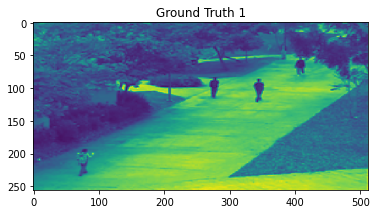

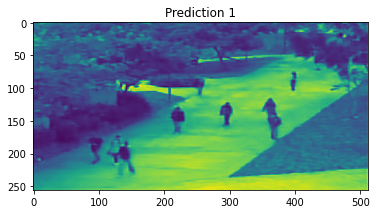

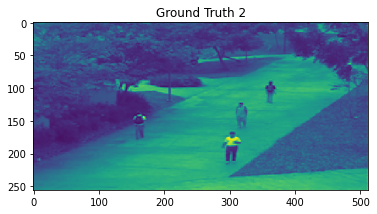

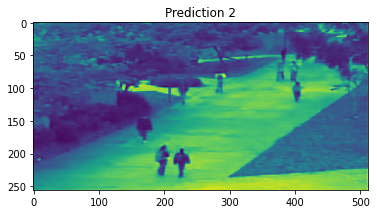

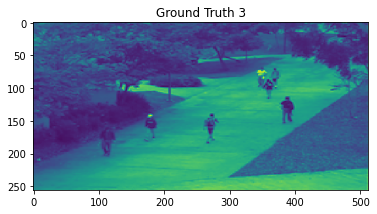

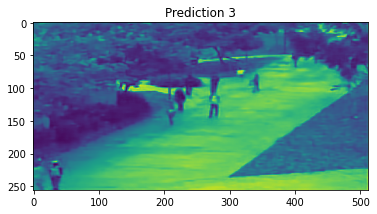

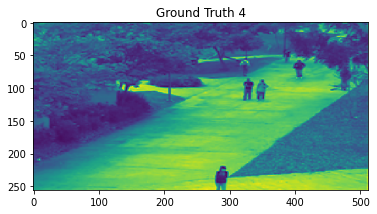

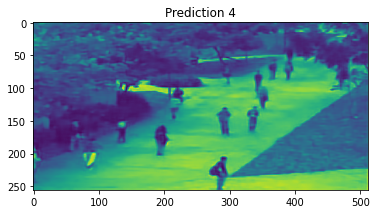

In [ ]:
predicted = model.predict(data_list[0])
no_of_samples = 4
idx = random.randint(no_of_samples, len(predicted))

for i in range(no_of_samples):
    img = data_list[idx+i][idx+i][:][:]
    plt.imshow(img[:,:,0])
    plt.title('Ground Truth ' + str(i+1))
    plt.show()

    img = predicted[idx+i][:][:]
    plt.imshow(img[:,:,0])
    plt.title('Prediction ' + str(i+1))
    plt.show()